In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [43]:
# Load the data
df = pd.read_csv('final_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%d-%m-%Y %H:%M')
df.set_index('datetime', inplace=True)

In [44]:
# Feature engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [45]:
# Create lag features
for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']:
    df[f'{target}_lag_1'] = df[target].shift(1)
    df[f'{target}_lag_24'] = df[target].shift(24)

In [46]:
# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

In [47]:
# Prepare features and target variables
categorical_features = ['weekday', 'hour', 'day_of_week', 'month', 'is_weekend']
numerical_features = ['temperature', 'humidity', 'wind_speed', 'precipitation'] + [f'{target}_lag_1' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']] + [f'{target}_lag_24' for target in ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']]
features = numerical_features + categorical_features
targets = ['DELHI', 'BRPL', 'BYPL', 'NDMC', 'MES']

In [48]:
# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [49]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [51]:
# Fit and transform the features
X = preprocessor.fit_transform(df)

In [52]:
# Normalize the target variables separately
y = np.zeros_like(df[targets].values)
scalers_y = {}
for i, target in enumerate(targets):
    scaler = StandardScaler()
    y[:, i] = scaler.fit_transform(df[[target]]).ravel()
    scalers_y[target] = scaler

In [53]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Reshape input data for GRU (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [62]:
# Build the improved GRU model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(256, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(targets))
])

In [63]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [64]:

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.2, 
                    verbose=1, callbacks=[early_stopping, lr_reducer])

Epoch 1/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 2.5506 - val_loss: 1.3165 - learning_rate: 0.0010
Epoch 2/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1236 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 3/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.8428 - val_loss: 0.8001 - learning_rate: 0.0010
Epoch 4/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.7026 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 5/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.6138 - val_loss: 0.4578 - learning_rate: 0.0010
Epoch 6/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.5593 - val_loss: 0.3942 - learning_rate: 0.0010
Epoch 7/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.5043 - val_loss: 0.3621 - learning_rate: 0.0010
Epoch 8/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4690 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 9/300
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.4399 - val_loss: 0.3135 - learning_rate

In [66]:
# Make predictions
y_pred = model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


In [67]:
# Inverse transform the predictions and actual values
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_test_inv[:, i] = scalers_y[target].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

In [68]:
y_test_inv[0]

array([3081.  , 1198.42,  711.82,  143.76,   23.85])

In [69]:
y_pred_inv[0]

array([4143.2144  , 1753.5398  ,  891.4382  ,  176.72353 ,   28.439344],
      dtype=float32)

In [39]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [70]:
y_pred

array([[-6.8747497e-05,  1.2938972e-03, -1.2157131e-03,  5.2216969e-04,
        -2.0500827e-03],
       [-2.8696104e-03,  1.3774921e-03,  1.0056314e-03,  7.6509314e-04,
        -8.5290946e-04],
       [-1.5826779e-05,  1.5316377e-03, -4.5939139e-04, -2.4692545e-04,
        -1.8692955e-03],
       ...,
       [-1.5458437e-03,  1.4811449e-03,  9.5095381e-04,  6.3728984e-04,
        -1.5821744e-03],
       [-6.9529307e-04, -1.5224342e-03, -4.5532615e-05, -2.0152475e-03,
        -1.4238730e-03],
       [-1.3119145e-04,  5.1418836e-03,  8.5437903e-05,  2.6102909e-03,
        -2.7779406e-03]], dtype=float32)

In [71]:
y_pred_inv

array([[4143.2144  , 1753.5398  ,  891.4382  ,  176.72353 ,   28.439344],
       [4139.4136  , 1753.5906  ,  892.1414  ,  176.73932 ,   28.449821],
       [4143.286   , 1753.6842  ,  891.6776  ,  176.67351 ,   28.440928],
       ...,
       [4141.21    , 1753.6534  ,  892.12415 ,  176.731   ,   28.44344 ],
       [4142.3643  , 1751.8293  ,  891.80865 ,  176.55852 ,   28.444826],
       [4143.13    , 1755.8768  ,  891.8501  ,  176.85931 ,   28.432976]],
      dtype=float32)

In [51]:
print(len(y_test))
print(y_test[0])
print(len(y_test))

2203
[-0.78283226 -0.91273064 -0.5685407  -0.50637795 -0.52645642]
2203


In [52]:
print(y_pred_inv[0])

[3285.4934   1364.2369    682.71136   148.84998    26.950632]


In [19]:
print(type(model)) 

<class 'keras.src.models.sequential.Sequential'>


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 256)              │         235,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1, 128)              │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 64)               │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,741 (1.65 MB)

 Trainable params: 431,781 (1.65 MB)

 Non-trainable params: 960 (3.75 KB)

In [65]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(model) 
  
# Load the pickled model 
from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
from_pickle.predict(X_test)

C:\Users\Anuska Palit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


array([[-6.8747497e-05,  1.2938972e-03, -1.2157131e-03,  5.2216969e-04,
        -2.0500827e-03],
       [-2.8696104e-03,  1.3774921e-03,  1.0056314e-03,  7.6509314e-04,
        -8.5290946e-04],
       [-1.5826779e-05,  1.5316377e-03, -4.5939139e-04, -2.4692545e-04,
        -1.8692955e-03],
       ...,
       [-1.5458437e-03,  1.4811449e-03,  9.5095381e-04,  6.3728984e-04,
        -1.5821744e-03],
       [-6.9529307e-04, -1.5224342e-03, -4.5532615e-05, -2.0152475e-03,
        -1.4238730e-03],
       [-1.3119145e-04,  5.1418836e-03,  8.5437903e-05,  2.6102909e-03,
        -2.7779406e-03]], dtype=float32)

In [42]:
from_pickle

<Sequential name=sequential, built=True>

In [25]:
train_predictions=from_pickle.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [26]:
train_predictions

array([[ 6.5072376e-04,  2.9424799e-04, -1.0334767e-03,  1.9597171e-03,
         1.1377231e-03],
       [ 5.8669696e-04,  2.7072526e-04, -4.7052372e-04,  1.2634076e-03,
         3.5044560e-03],
       [-2.4974295e-03, -1.5462644e-03, -1.8263294e-05,  2.5950735e-03,
         1.7068055e-03],
       ...,
       [ 2.1614938e-04, -4.8305761e-04, -1.9349607e-03,  2.5464573e-03,
         2.4472289e-03],
       [ 3.2036431e-04, -6.3075495e-05,  9.1677101e-04,  1.1682638e-03,
         2.5211443e-04],
       [-2.2693542e-03, -4.9692491e-04, -1.1060224e-03,  1.7267558e-03,
         3.4593602e-03]], dtype=float32)

In [26]:
y_test[0]

array([-0.78283226, -0.91273064, -0.5685407 , -0.50637795, -0.52645642])

In [27]:
X_test[0]

array([[-1.49502479,  0.25284277, -0.64019975, -0.22189355, -0.56143848,
        -0.67419267, -0.34045397, -0.38910747, -0.06877005, -0.33570261,
        -0.49673279, -0.33833424,  0.36458445,  1.08462212,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
X_test.shape

(2203, 1, 49)

In [52]:
train_predictions[0]

28.437843

In [55]:
for i in range(11):
    print("Day",i,"is :",train_predictions[i])
    print()

Day 0 is : 28.437843

Day 1 is : 28.472082

Day 2 is : 28.450668

Day 3 is : 28.46435

Day 4 is : 28.474512

Day 5 is : 28.403378

Day 6 is : 28.460657

Day 7 is : 28.51006

Day 8 is : 28.477692

Day 9 is : 28.509958

Day 10 is : 28.422022



In [56]:
train_predictions

array([28.437843, 28.472082, 28.450668, ..., 28.460752, 28.480684,
       28.492393], dtype=float32)

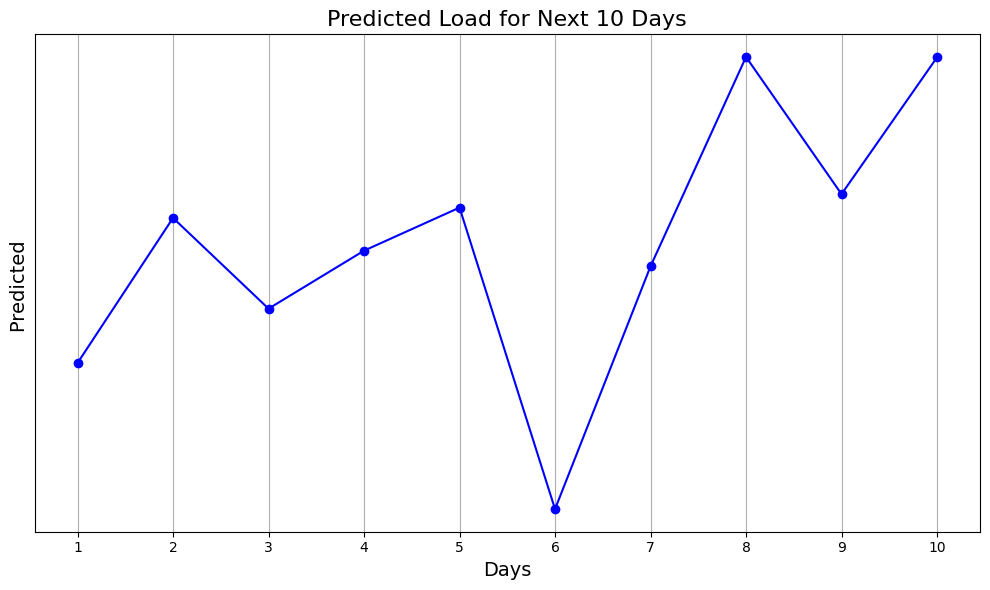

In [57]:
days = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(days, train_predictions[:10], marker='o', linestyle='-', color='b')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Predicted ', fontsize=14)
plt.title('Predicted Load for Next 10 Days', fontsize=16)
plt.xticks(days)
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Inverse transform the predictions and actual values
train_predictions = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

In [28]:
y_pred_inv

array([[4144.191   , 1752.9326  ,  891.49585 ,  176.817   ,   28.467243],
       [4144.104   , 1752.9183  ,  891.6741  ,  176.77173 ,   28.487955],
       [4139.919   , 1751.8148  ,  891.81726 ,  176.85832 ,   28.472223],
       ...,
       [4143.601   , 1752.4606  ,  891.21045 ,  176.85516 ,   28.478703],
       [4143.7427  , 1752.7157  ,  892.11334 ,  176.76553 ,   28.459494],
       [4140.228   , 1752.4521  ,  891.4729  ,  176.80185 ,   28.48756 ]],
      dtype=float32)

In [30]:
# Inverse transform the predictions and actual values
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)
for i, target in enumerate(targets):
    y_test_inv[:, i] = scalers_y[target].inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scalers_y[target].inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

In [31]:
y_test_inv

array([[3081.  , 1198.42,  711.82,  143.76,   23.85],
       [6288.81, 2631.62, 1376.82,  309.9 ,   48.5 ],
       [4981.98, 2133.51, 1135.33,  202.39,   27.31],
       ...,
       [4970.9 , 2052.77, 1047.69,  289.8 ,   35.95],
       [3663.03, 1344.42,  785.12,  129.57,   19.12],
       [6321.55, 2602.41, 1359.33,  337.17,   42.85]])

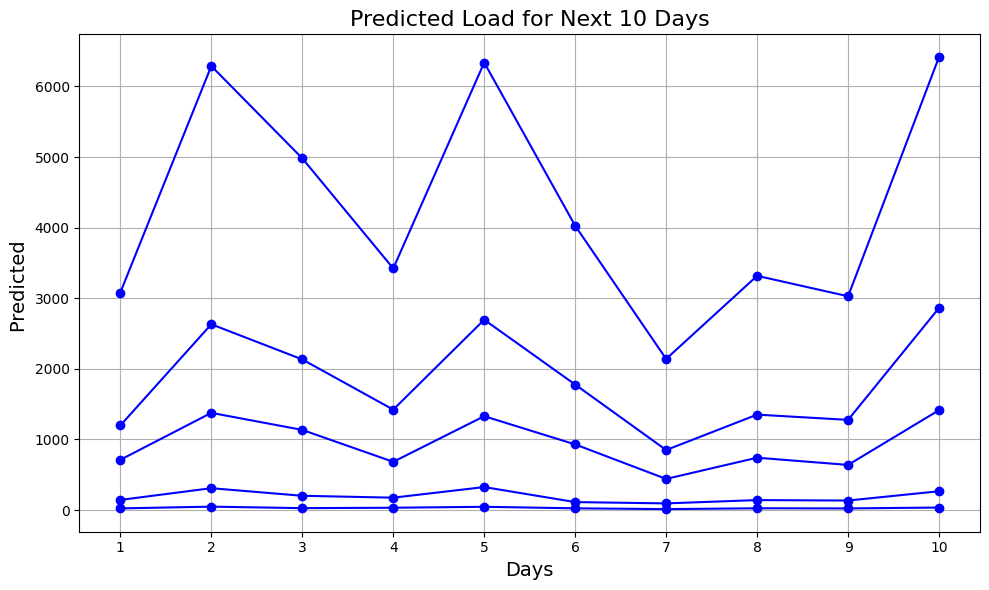

In [34]:
days = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(days, y_test_inv[:10], marker='o', linestyle='-', color='b')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Predicted ', fontsize=14)
plt.title('Predicted Load for Next 10 Days', fontsize=16)
plt.xticks(days)
plt.grid(True)
plt.tight_layout()
plt.show()